In [ ]:
# Change log

# v5 (Stas):
# added risk free asset (SOFR) to the portfolio


# v4 (Stas):
# added Sharpe ratio as a optimization goal
# annualized time series of returns in preprocessing stage
# added option to use or not use random sampling from the matrix
# minor visualization changes

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import numpy.linalg as la
import scipy.optimize as optimize
import seaborn as sns
import matplotlib.pyplot as plt
import time

[*********************100%***********************]  99 of 99 completed


Correlation Matrix of Stock Returns:


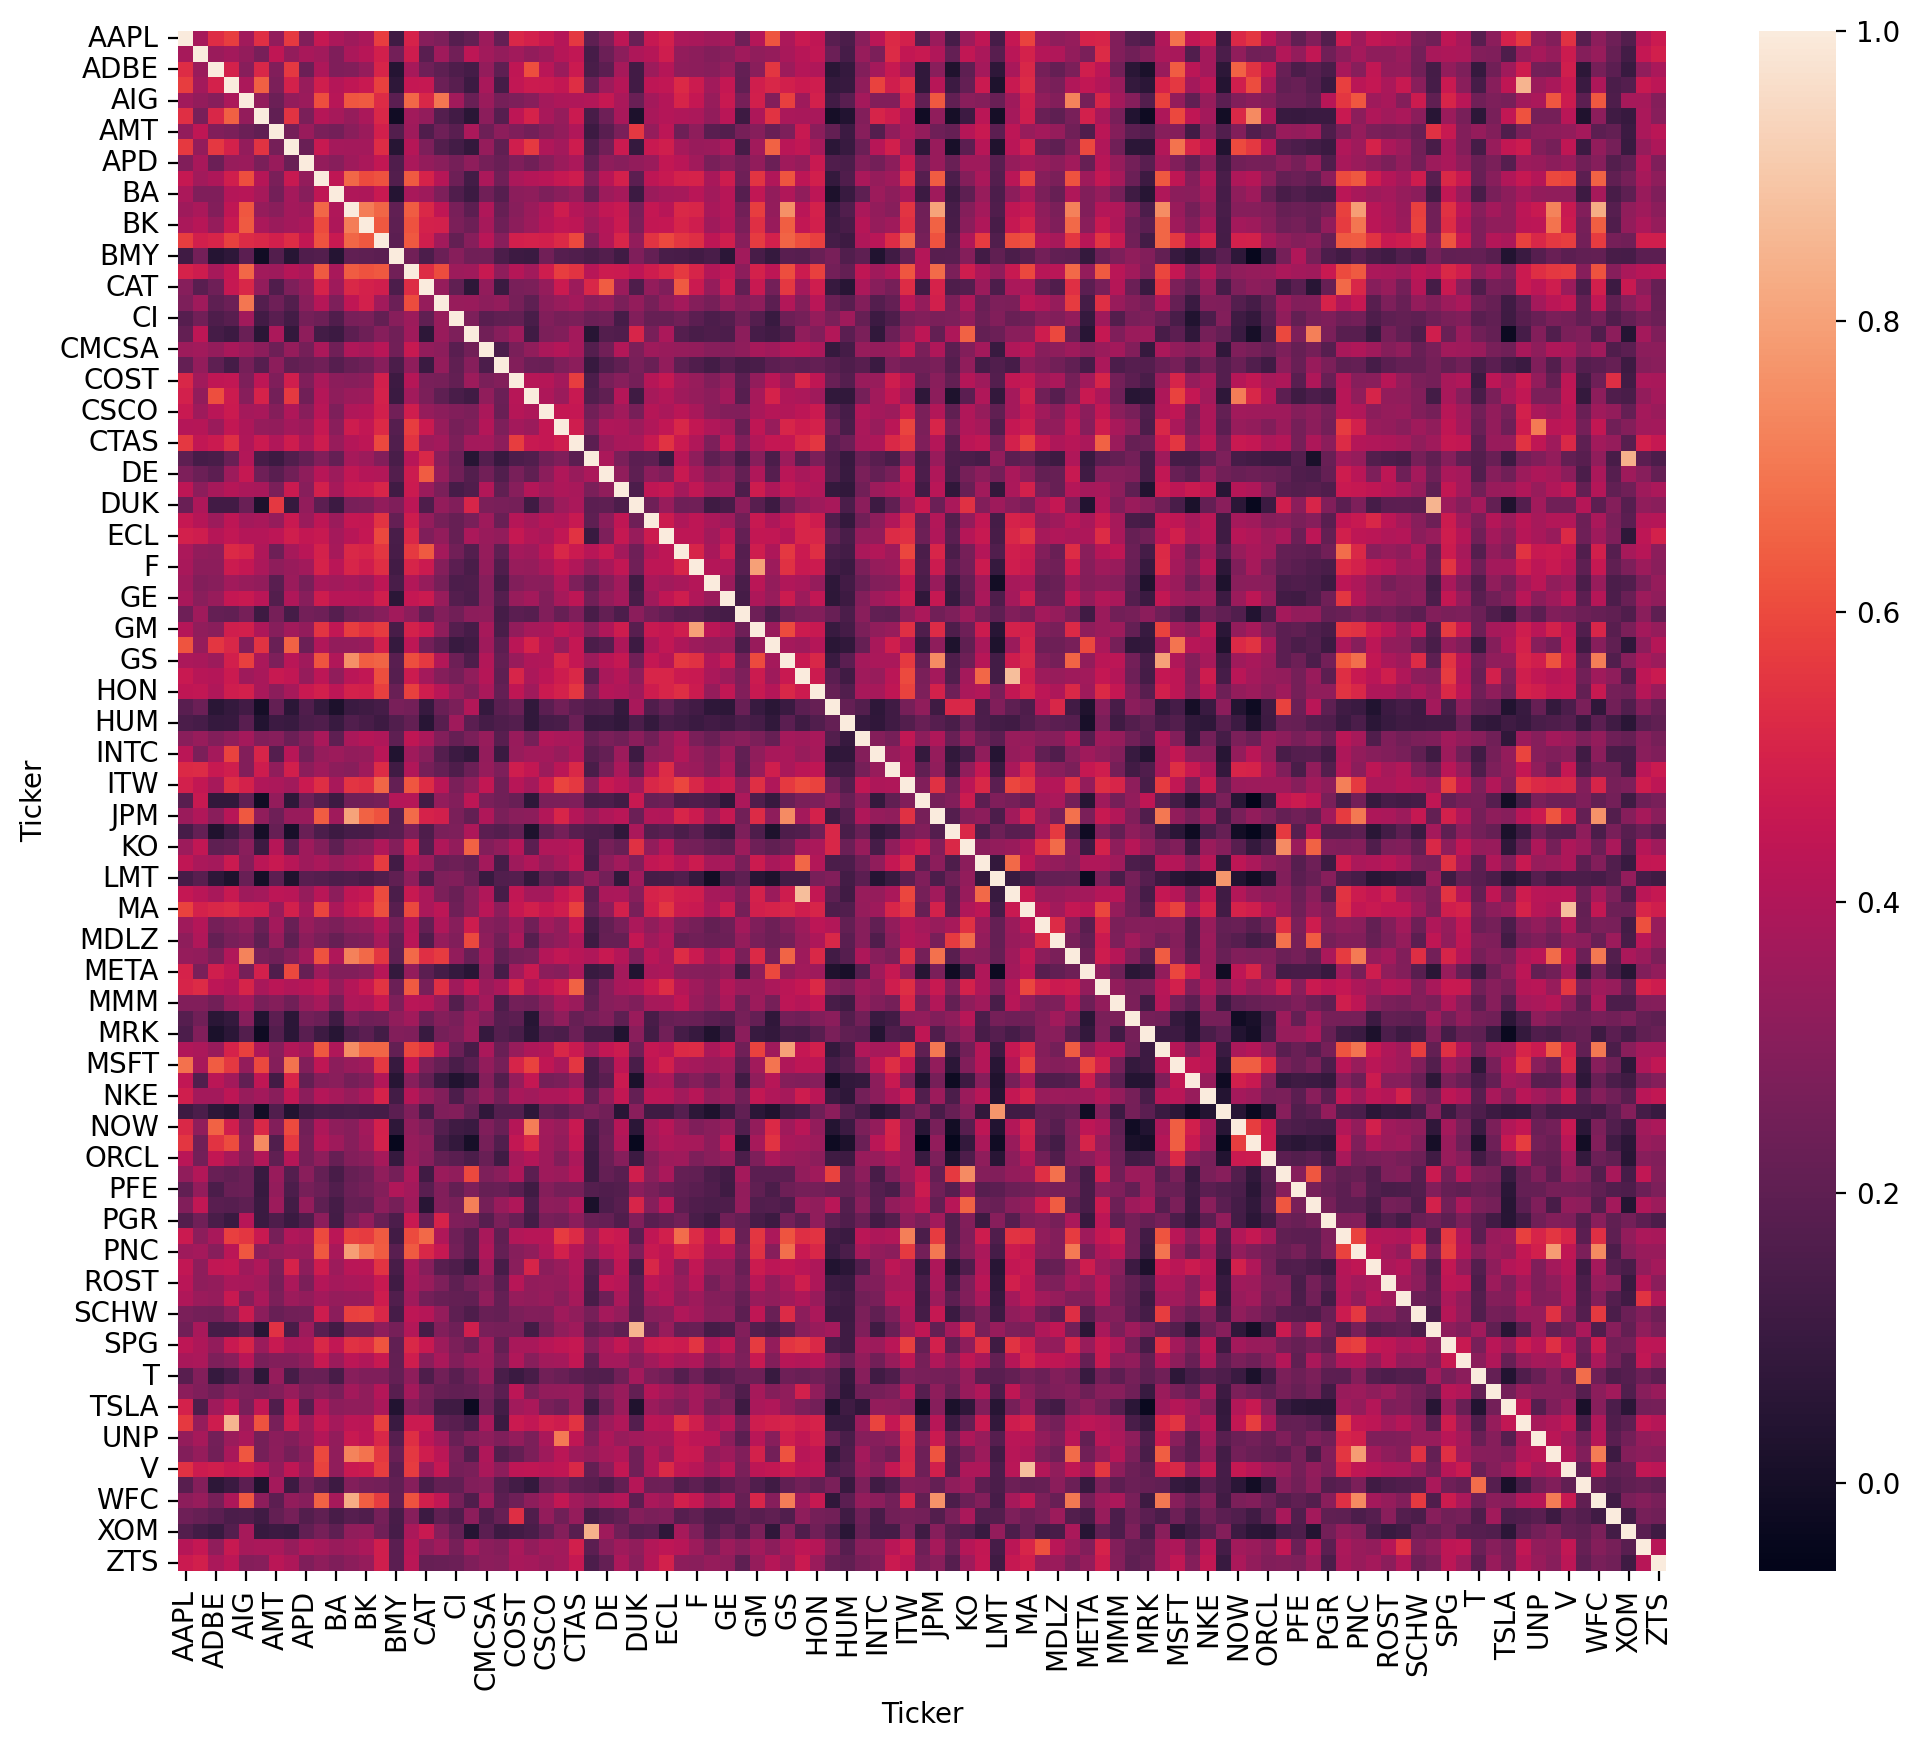

In [3]:
# Функция для загрузки данных о ценах акций
def fetch_stock_data(tickers, start_date='2022-01-01', end_date=None):
    if end_date is None:
        end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
    try:
        stocks_data = yf.download(tickers, start=start_date, end=end_date)
        return stocks_data['Adj Close']
    except Exception as e:
        print(f"Error importing stocks: {e}")
        return None

# Функция для расчёта доходностей
def calculate_returns(prices):
    return prices.pct_change().dropna()

# Список тикеров
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'META', 'NVDA', 'BRK-B', 'JPM', 'JNJ',
    'WMT', 'PG', 'V', 'DIS', 'MA', 'HD', 'PYPL', 'NFLX', 'BAC', 'KO',
    'PFE', 'T', 'XOM', 'MRK', 'PEP', 'NKE', 'CSCO', 'ABT', 'INTC', 'CMCSA',
    'MCD', 'COST', 'VZ', 'WFC', 'ADBE', 'CRM', 'AMD', 'HON', 'AMT', 'UNP',
    'CAT', 'GS', 'LMT', 'BA', 'IBM', 'BLK', 'MMM', 'AXP', 'CVX', 'TGT',
    'GE', 'LOW', 'ORCL', 'F', 'SPG', 'MS', 'TXN', 'CI', 'ISRG', 'NOW',
    'DUK', 'SBUX', 'BK', 'USB', 'MO', 'GM', 'AIG', 'PNC', 'SO', 'MDLZ',
    'SCHW', 'ADI', 'ITW', 'ECL', 'MMC', 'CL', 'CME', 'BMY', 'CSX', 'DE',
    'ZTS', 'GILD', 'MET', 'CB', 'FDX', 'APD', 'NOC', 'PGR', 'EMR', 'ADI',
    'KHC', 'PH', 'ROST', 'HUM', 'EBAY', 'HSY', 'SYY', 'LEN', 'CTAS', 'YUM'
]


    # Получаем данные о ценах
stock_prices = fetch_stock_data(tickers)

if stock_prices is not None:
        # Рассчитываем доходности
  returns = calculate_returns(stock_prices)

        # Рассчитываем ковариационную матрицу
  correlation_matrix = returns.corr()

        # Выводим ковариационную матрицу
  print("Correlation Matrix of Stock Returns:")
  plt.figure(figsize=(12, 10), dpi = 200)
  sns.heatmap(correlation_matrix)
  plt.show()
#   print(correlation_matrix)




In [4]:
class MatrixApproximator:
    def __init__(self, sampling_ratio=0.5, random_seed=42):
        """
        Initialize the matrix approximation algorithm.
        Args:
            sampling_ratio (float): Proportion of matrix entries to sample
            random_seed (int): Random seed for reproducibility
        """
        np.random.seed(random_seed)
        self.sampling_ratio = sampling_ratio

    def sample_matrix(self, A):
        """
        Randomly sample entries of the input matrix.
        Args:
            A (np.ndarray): Input matrix
        Returns:
            np.ndarray: Sampled matrix with some entries set to zero
        """
        mask = np.random.rand(*A.shape) < self.sampling_ratio
        return A * mask

    def lanczos_iteration(self, A, k):
        """
        Perform Lanczos iteration to compute rank-k approximation.
        Args:
            A (np.ndarray): Input matrix
            k (int): Desired rank of approximation
        Returns:
            np.ndarray: Rank-k approximation of the matrix
        """
        U, S, Vt = la.svd(A, full_matrices=False)
        Ak = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]
        return Ak

    def approximate(self, A, k):
        """
        Compute a near-optimal rank-k approximation.
        Args:
            A (np.ndarray): Input matrix
            k (int): Desired rank of approximation
        Returns:
            dict: Contains original and approximated matrices, and error metrics
        """
        A_optimal_k = self.lanczos_iteration(A, k)
        A_sampled = self.sample_matrix(A)
        A_sampled_k = self.lanczos_iteration(A_sampled, k)

        frobenius_error_original = la.norm(A - A_optimal_k, 'fro')
        frobenius_error_sampled = la.norm(A - A_sampled_k, 'fro')

        return {
            'original_matrix': A,
            'optimal_k_approximation': A_optimal_k,
            'sampled_approximation': A_sampled_k,
            'error_original_k': frobenius_error_original,
            'error_sampled_k': frobenius_error_sampled,
            'relative_error': frobenius_error_sampled / frobenius_error_original
        }

In [5]:


class InvestmentRecommender:
    def __init__(self, historical_returns, risk_appetite = 0.5, method = ['fullrank', 'lowrank', 'random_lowrank'], approximation_rank = 20, sampling_ratio = 0.5, 
                 target_function = ['balanced', 'sharpe', 'max_return', 'min_risk']):

        self.returns = historical_returns
        self.assets = self.returns.columns
        self.risk_appetite = risk_appetite
        self.method = method
        self.approximation_rank = approximation_rank
        self.sampling_ratio = sampling_ratio
        self.target_function = target_function

        # perform basic calculations, create instance of MatrixApproximator class
        self.matrix_approximator = MatrixApproximator(sampling_ratio=self.sampling_ratio)  
        self._preprocess_returns()
        self._calculate_asset_metrics()
           

    def _preprocess_returns(self):
        # remove outliers, annualize
        self.cleaned_returns = self.returns.apply(lambda x: x[(x - x.mean()).abs() <= 3 * x.std()]) * 252

        # Fill in NaNs
        self.cleaned_returns.fillna(self.cleaned_returns.mean(), inplace=True)

    def _calculate_asset_metrics(self):

        # Average return for each asset
        self.avg_returns = self.cleaned_returns.mean()

        # Volatility estimate
        self.volatilities = self.cleaned_returns.std()

        # Covariance matrix with desired approximation method (fullrank, lowrank and random lowrank)
        self.cov_matrix = self._approximate_covariance()

    def _approximate_covariance(self, sampling_ratio=0.6):
        # Calculate initial covariance matrix
        original_cov = np.cov(self.cleaned_returns.values.T)

        # Call approximator function
        approximation_result = self.matrix_approximator.approximate(original_cov, k=self.approximation_rank)

        if self.method == 'random_lowrank':
            return approximation_result['sampled_approximation']
        elif self.method == 'lowrank':
            return approximation_result['optimal_k_approximation']
        else:
            return approximation_result['original_matrix']

    def portfolio_metrics(self, weights):
        portfolio_return = np.sum(self.avg_returns * weights)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - 0.0465) / portfolio_risk

        return {'return': portfolio_return, 'risk': portfolio_risk, 'sharpe_ratio': sharpe_ratio}
    
    def objective_function(self, weights):
        metrics = self.portfolio_metrics(weights)

        if self.target_function == 'balanced':
            return -(metrics['return'] * (1 - self.risk_appetite) -metrics['risk'] * self.risk_appetite)
            
        elif self.target_function == 'sharpe':
            return -metrics['sharpe_ratio']

        elif self.target_function == 'max_return':
            return -metrics['return']

        elif self.target_function == 'min_risk':
            return metrics['risk']
        
        else:
            raise ValueError("Unsupported optimization target")

    def optimize_portfolio(self):
        """
        Оптимизация портфеля с учетом различных стратегий

        Args:
        - optimization_type (str): Тип оптимизации
          ('balanced', 'max_return', 'min_risk')

        Returns:
        - dict: Оптимальный портфель
        """
        n_assets = len(self.assets)

        # Базовые ограничения
        bounds = tuple((0, 0.3) for _ in range(n_assets))
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})


        # Начальное распределение
        initial_weights = np.ones(n_assets) / n_assets

        # Оптимизация
        result = optimize.minimize(
            self.objective_function,
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        # Метрики оптимального портфеля
        optimal_weights = result.x
        portfolio_metrics = self.portfolio_metrics(optimal_weights)

        return {
            'weights': pd.Series(optimal_weights, index=self.assets),
            'metrics': portfolio_metrics
        }

    def visualize_portfolio(self, weights):
        """
        Визуализация распределения портфеля

        Args:
        - weights (pd.Series): Веса активов
        """
        plt.figure(figsize=(12, 6))

        # Круговая диаграмма распределения
        plt.subplot(121)
        weights.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Распределение активов')

        # Bar plot доходностей
        plt.subplot(122)
        pd.Series(
            weights * self.avg_returns,
            index=self.assets
        ).plot(kind='bar')
        plt.title('Вклад каждого актива')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    def recommend_strategy(self):
        return self.optimize_portfolio()

In [6]:
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'META', 'NVDA', 'BRK-B', 'JPM', 'JNJ', 'WMT', 'PG', 'V', 'DIS', 'MA', 'HD', 'PYPL', 'NFLX', 'BAC', 'KO', 'PFE', 'T', 'XOM', 'MRK', 'PEP', 'NKE', 'CSCO', 'ABT', 'INTC', 'CMCSA', 'MCD', 'COST', 'VZ', 'WFC', 'ADBE', 'CRM', 'AMD', 'HON', 'AMT', 'UNP', 'CAT', 'GS', 'LMT', 'BA', 'IBM', 'BLK', 'MMM', 'AXP', 'CVX', 'TGT', 'GE', 'LOW', 'ORCL', 'F', 'SPG', 'MS', 'TXN', 'CI', 'ISRG', 'NOW', 'DUK', 'SBUX', 'BK', 'USB', 'MO', 'GM', 'AIG', 'PNC', 'SO', 'MDLZ', 'SCHW', 'ADI', 'ITW', 'ECL', 'MMC', 'CL', 'CME', 'BMY', 'CSX', 'DE', 'ZTS', 'GILD', 'MET', 'CB', 'FDX', 'APD', 'NOC', 'PGR', 'EMR', 'ADI', 'KHC', 'PH', 'ROST', 'HUM', 'EBAY', 'HSY', 'SYY', 'LEN', 'YUM', 'ADP', 'AMGN', 'AON', 'APD', 'AIG', 'BAX', 'BMY', 'CARR', 'CDW', 'CLX', 'COP', 'DHR', 'DOV', 'DXCM', 'ECL', 'EL', 'EMR', 'FISV', 'GD', 'GWW', 'HIG', 'HLT', 'HPE', 'HSIC', 'IDXX', 'ILMN', 'KMB', 'LHX', 'LMT', 'MAR', 'MET', 'MSFT', 'NDAQ', 'NTRS', 'OXY', 'PAYC', 'PGR', 'RMD', 'SBUX', 'SHW', 'SPG', 'SYK', 'TROW', 'TTWO', 'UNH', 'VFC', 'VLO', 'WBA', 'WDC', 'WMB', 'WRB', 'XRAY', 'ZBRA', 'ZTS', 'RY', 'MFC', 'TEM', 'BTI', 'UPS', 'SSL', 'AA', 'TEVA', 'KEP', 'MRO', 'NGG', 'GILD', 'SLF', 'PUK', 'CX', 'BK', 'CNI', 'IP', 'CSCO', 'FITB', 'WIT', 'NCC', 'NOC', 'AMRC', 'AMRN', 'AMPY', 'ANSS', 'ADMA', 'ADN', 'ADNT', 'ADPT', 'AEO', 'AEIS', 'AEMD', 'AENT', 'AEP', 'AER', 'AHG', 'AHH', 'AI', 'AIEV', 'AIHS', 'AKAM', 'AKRO', 'AKTX', 'AMRK', 'AMST', 'RBRK', 'BOW', 'UMAC', 'AHR', 'ZSPC', 'LOAR', 'ALAB', 'LB', 'RDDT', 'NNE', 'BCHT', 'PFIG', 'VZLA', 'GLDX', 'JEPQ', 'XFLX', 'AGG', 'SOBO', 'MORE', 'UTES', 'MSHE', 'COPR', 'FTHI', 'EVO', 'GFR', 'ABNB', 'GLBE', 'LMND', 'LULU', 'MELI', 'NU', 'SOFI', 'TWLO', 'RBLX', 'SNOW', 'DOCU', 'CRWD', 'ZIM', 'PINS', 'PLTR', 'FSLY', 'ZM', 'SQ', 'RNG', 'FVRR', 'SHOP', 'DDOG', 'CLOV', 'RIVN', 'BYND', 'DASH', 'HIMS', 'CZR', 'PDD', 'BMBL', 'NIO', 'XPEV', 'LI', 'FUV', 'WKHS', 'CFLT', 'SNAP', 'SPOT', 'TTD', 'ETSY', 'ROKU', 'MARA', 'RIOT', 'COIN', 'SBUX', 'BABA', 'JD', 'TCEHY', 'SE', 'BIDU', 'NKE', 'LVS', 'MGM', 'WYNN', 'CCL', 'RCL', 'HLT', 'MAR', 'HST', 'IHG', 'DHI', 'LEN', 'PHM', 'KBH', 'TOL', 'NVR', 'MTH', 'ZWS', 'AXTA', 'VTRS', 'HBI', 'KMX', 'ANSS', 'CDW', 'DXCM', 'EXPE', 'GRMN', 'HIG', 'JCI', 'KMB', 'LDOS', 'PNC'
]

In [ ]:
stock_prices = fetch_stock_data(tickers)

[*********************100%***********************]  279 of 279 completed


In [202]:
import warnings
warnings.filterwarnings("ignore")

n_stocks = [10*i for i in range(1, 28)]
n_stocks.append(279)
methods = ['random_lowrank', 'lowrank', 'fullrank']


res = np.zeros((3, len(n_stocks), 10))

for k in range(len(methods)):
    for i in range(len(n_stocks)):
        for j in range(10):
            stock_prices_temp = stock_prices.iloc[:, :n_stocks[i]]
            historical_returns = calculate_returns(stock_prices_temp)
            historical_returns["SOFR"] = 0.0465 / 252

            recommender = InvestmentRecommender(historical_returns, risk_appetite=0.5, method = methods[k],
                                                approximation_rank=50, sampling_ratio=0.5, target_function = 'sharpe')
            start_time = time.time()

            output = recommender.recommend_strategy()
            # print(f"Resulting Sharpe ratio: {output['metrics']}")

            close_time = time.time()-start_time
            # print(f"Number of stocks: {n_stocks[i]}, time: {close_time}")
            res[k, i, j] = close_time
        print(f"{n_stocks[i]} stocks scenario with method {methods[k]} done.")
    print(f"{methods[k]} done.")

10 stocks scenario with method random_lowrank done.
20 stocks scenario with method random_lowrank done.
30 stocks scenario with method random_lowrank done.
40 stocks scenario with method random_lowrank done.
50 stocks scenario with method random_lowrank done.
60 stocks scenario with method random_lowrank done.
70 stocks scenario with method random_lowrank done.
80 stocks scenario with method random_lowrank done.
90 stocks scenario with method random_lowrank done.
100 stocks scenario with method random_lowrank done.
110 stocks scenario with method random_lowrank done.
120 stocks scenario with method random_lowrank done.
130 stocks scenario with method random_lowrank done.
140 stocks scenario with method random_lowrank done.
150 stocks scenario with method random_lowrank done.
160 stocks scenario with method random_lowrank done.
170 stocks scenario with method random_lowrank done.
180 stocks scenario with method random_lowrank done.
190 stocks scenario with method random_lowrank done.
20

In [ ]:
random_lowrank = res[0].mean(axis = 1)
lowrank = res[1].mean(axis = 1)
fullrank = res[2].mean(axis = 1)


In [209]:
# plt.figure(figsize=(10,5), dpi = 200)
# plt.plot(n_stocks, lowrank)
# plt.plot(n_stocks, random_lowrank)
# plt.plot(n_stocks, fullrank)
# plt.legend(['lowrank', 'random lowrank', 'fullrank'])
# plt.xlabel('Number of stocks')
# plt.ylabel('Time (sec)')

# plt.show()

In [210]:
historical_returns = calculate_returns(stock_prices_temp)
historical_returns["SOFR"] = 0.0465 / 252

recommender = InvestmentRecommender(historical_returns, risk_appetite=0.5, method = 'lowrank',
                                    approximation_rank=50, sampling_ratio=0.5, target_function = 'sharpe')

start_time = time.time()

output = recommender.recommend_strategy()
print(f"Resulting Sharpe ratio: {output['metrics']}")

close_time = time.time()-start_time
print('TIME: ',close_time)

Resulting Sharpe ratio: {'return': np.float64(4.5817566824675735), 'risk': np.float64(0.0021913490333635957), 'sharpe_ratio': np.float64(2069.618583538111)}
TIME:  5.799688339233398


In [ ]:
# 23.01 sec - fullrank
# 14.87 sec - lowrank
# 8.33 sec - random lowrank